# Лабораторна робота №3 — k-Nearest Neighbour (Lazy learner)

Студентка: Olena Mykhailovska, Group: CS-31, STUDENT_NO = 13

Мета: провести експерименти k-NN на датасеті `nasa.csv`:
- EDA і препроцесинг;
- розділення train/val/test (stratify);
- експерименти по метрикам: 'euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev', 'mahalanobis';
- варіювати mem_percent (частка збережених прикладів) і k (непарні);
- використовувати `f1_macro`, `precision_macro`, `recall_macro` як основні метрики (особливо якщо дані незбалансовані);
- зберегти результати в CSV і вивести кращі конфігурації;
- побудувати confusion matrix для тесту та візуалізації (PCA → 2D decision boundary).


In [3]:
# Блок 1: імпорти та налаштування
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors._base import DistanceMetric

import seaborn as sns
import plotly.express as px

# Налаштування відображення
pd.set_option('display.max_columns', 200)
np.random.seed(13)  # використаємо STUDENT_NO як сид


Завантажимо `nasa.csv` і переглянемо перші рядки та типи колонок, пропуски, базову статистику.


In [4]:
# Блок 2: завантаження та EDA
df = pd.read_csv('nasa.csv')  # поклади nasa.csv поряд зі скриптом

print('Розмір датасету:', df.shape)
display(df.head(8))
display(df.info())
display(df.describe(include='all').T)

# Перевірка пропусків
print('Пропуски по колонках:')
print(df.isna().sum().sort_values(ascending=False).head(20))


Розмір датасету: (4687, 40)


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True
5,3671135,3671135,19.6,0.319562,0.714562,319.561887,714.562102,0.198566,0.444008,1048.431420,2344.363926,1995-01-15,790156800000,10.808844,38911.838251,24178.303051,0.392785,152.793274,58759768.0,36511628.0,Earth,40,2017-06-04 06:16:52,1,0.272213,4.724,2458000.5,0.563441,1.323532,17.927751,178.971951,556.160556,0.577800,198.145969,2.069265,2.458009e+06,354.237368,0.647295,J2000,False
6,2495323,2495323,19.6,0.319562,0.714562,319.561887,714.562102,0.198566,0.444008,1048.431420,2344.363926,1995-01-15,790156800000,10.808842,38911.829716,24178.297748,0.392783,152.792664,58759532.0,36511480.0,Earth,43,2017-06-28 06:19:25,1,0.272213,4.724,2458000.5,0.563441,1.323532,17.927748,178.971953,556.160544,0.577800,198.145960,2.069265,2.458009e+06,354.237396,0.647295,J2000,False
7,2153315,2153315,19.2,0.384198,0.859093,384.197891,859.092601,0.238729,0.533815,1260.491809,2818.545370,1995-01-22,790761600000,24.421884,87918.782382,54629.312308,0.129179,50.250694,19324928.0,12007954.0,Earth,22,2017-04-06 09:27:05,0,0.098758,4.921,2458000.5,0.449763,1.237475,34.695127,112.562984,502.808758,0.680905,288.374651,1.794045,2.458242e+06,186.776932,0.715978,J2000,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Neo Reference ID,4687.0,NaN,NaN,NaN,3272297.771709,548601.083264,2000433.0,3097593.5,3514799.0,3690059.5,3781897.0
Name,4687.0,NaN,NaN,NaN,3272297.771709,548601.083264,2000433.0,3097593.5,3514799.0,3690059.5,3781897.0
Absolute Magnitude,4687.0,NaN,NaN,NaN,22.267865,2.890972,11.16,20.1,21.9,24.5,32.1
Est Dia in KM(min),4687.0,NaN,NaN,NaN,0.204604,0.369573,0.001011,0.033462,0.110804,0.253837,15.579552
Est Dia in KM(max),4687.0,NaN,NaN,NaN,0.457509,0.826391,0.00226,0.074824,0.247765,0.567597,34.836938
Est Dia in M(min),4687.0,NaN,NaN,NaN,204.604203,369.573402,1.010543,33.462237,110.803882,253.837029,15579.552413
Est Dia in M(max),4687.0,NaN,NaN,NaN,457.508906,826.391249,2.259644,74.823838,247.765013,567.596853,34836.938254
Est Dia in Miles(min),4687.0,NaN,NaN,NaN,0.127135,0.229642,0.000628,0.020792,0.06885,0.157727,9.680682
Est Dia in Miles(max),4687.0,NaN,NaN,NaN,0.284283,0.513496,0.001404,0.046493,0.153954,0.352688,21.646663
Est Dia in Feet(min),4687.0,NaN,NaN,NaN,671.273653,1212.511199,3.315431,109.784247,363.529809,832.798679,51114.018738


Пропуски по колонках:
Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
dtype: int64


In [9]:
# -----------------------------
# Блок 6: Підготовка X та y
# -----------------------------

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Явно вказуємо колонку з таргетом ---
label_col = 'Hazardous'

# --- Викидаємо ID/name колонки ---
drop_cols = [c for c in ['Neo Reference ID', 'Name', 'name', 'id', 'Id'] if c in df.columns]
print("Викидаємо колонки:", drop_cols)

# --- Формуємо X та y ---
X_df = df.drop(columns=drop_cols + [label_col], errors='ignore').copy()
y_series = df[label_col].copy()

# --- Якщо таргет не числовий, застосуємо LabelEncoder ---
if y_series.dtype == 'object' or y_series.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y_series.astype(str))
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('Label mapping:', label_mapping)
else:
    y = y_series.values

# --- Обробка пропусків у X ---
if X_df.isna().sum().sum() > 0:
    print('Заповнюємо пропуски медианою по стовпцях.')
    X_df = X_df.fillna(X_df.median(numeric_only=True))

# --- Відбираємо тільки числові колонки для k-NN ---
numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
print('Використовуємо числові колонки:', numeric_cols)
X = X_df[numeric_cols].values

# --- Масштабування фіч ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Розмір X_scaled:', X_scaled.shape)
print('Розмір y:', y.shape)


Викидаємо колонки: ['Neo Reference ID', 'Name']
Використовуємо числові колонки: ['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Epoch Date Close Approach', 'Relative Velocity km per sec', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbit ID', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']
Розмір X_scaled: (4687, 33)
Розмір y: (4687,)


Розділимо дані у співвідношенні train 60% / val 20% / test 20% (приклад). Для небалансованих класів обов'язково stratify=y.


In [10]:
# Блок 4: train/val/test split (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=13, stratify=y
)

# із проміжного набору виділимо validation (0.25 від проміжного => 0.6/0.2/0.2)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=13, stratify=y_temp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Train: (2811, 33) Val: (938, 33) Test: (938, 33)


Додаємо функції: `plot_classifier_boundary` (на PCA-2D проекції) та evaluate_model. Для plotting ми навчаємо окрему KNN на PCA-проекції, щоб візуалізувати кордони легко.


In [11]:
# Блок 5: корисні функції

def plot_classifier_boundary_pca(X_orig, y_orig, model=None, title=None, resolution=200):
    """
    Проекція X_orig у 2D через PCA і побудова decision boundary (якщо model заданий — тренований на PCA-просторі).
    Якщо model==None — просто scatter plot.
    """
    pca = PCA(n_components=2, random_state=13)
    X2 = pca.fit_transform(X_orig)

    # Якщо model є, очікуємо що він тренований на X2 (тобто потрібно тренувати модель окремо на X2 перед викликом)
    plt.figure(figsize=(8,8))
    if model is not None:
        x1_min, x1_max = X2[:,0].min()-0.2, X2[:,0].max()+0.2
        x2_min, x2_max = X2[:,1].min()-0.2, X2[:,1].max()+0.2
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, resolution),
                               np.linspace(x2_min, x2_max, resolution))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict(grid)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=plt.cm.coolwarm)

    scatter = plt.scatter(X2[:,0], X2[:,1], c=y_orig, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    if title is None:
        title = 'PCA 2D scatter' if model is None else 'PCA 2D decision boundary'
    plt.title(title)
    plt.show()


def evaluate_and_report(model, X_eval, y_eval, target_names=None):
    y_pred = model.predict(X_eval)
    f1 = f1_score(y_eval, y_pred, average='macro')
    prec = precision_score(y_eval, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_eval, y_pred, average='macro', zero_division=0)
    return {'f1_macro': f1, 'precision_macro': prec, 'recall_macro': rec}


Список метрик: ['euclidean','manhattan','minkowski','cosine','chebyshev','mahalanobis'].
Для 'mahalanobis' потрібно передати параметр VI (обернена коваріаційна матриця). Використаємо псевдо-інверсію, щоб уникнути проблем з виродженістю.
Експериментуємо по mem_percent: від 0.05 до 0.95 з кроком 0.1 (можеш змінити).
k — непарні від 1 до min(51, n_train мемозбережених).
Оцінюємо на валідації; зберігаємо результати.


In [15]:
# -----------------------------
# Блок 6: Підготовка X та y (NASA Hazardous)
# -----------------------------
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Перевіримо, що колонка Hazardous є
if 'Hazardous' not in df.columns:
    raise ValueError("У датасеті немає колонки 'Hazardous' для таргету!")

label_col = 'Hazardous'
y_series = df[label_col].copy()

# Label encode для Yes/No
le = LabelEncoder()
y = le.fit_transform(y_series.astype(str))
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

# Викидаємо ID/name колонки
drop_cols = [c for c in ['Neo Reference ID', 'Name', 'name', 'id', 'Id', label_col] if c in df.columns]
print("Викидаємо колонки:", drop_cols)

# Формуємо X
X_df = df.drop(columns=drop_cols).copy()

# Заповнення пропусків медианою
if X_df.isna().sum().sum() > 0:
    print("Заповнюємо пропуски медианою по числових стовпцях.")
    X_df = X_df.fillna(X_df.median(numeric_only=True))

# Беремо лише числові колонки
numeric_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
print("Використовуємо числові колонки:", numeric_cols)
X = X_df[numeric_cols].values

# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Label mapping: {'False': np.int64(0), 'True': np.int64(1)}
Викидаємо колонки: ['Neo Reference ID', 'Name', 'Hazardous']
Використовуємо числові колонки: ['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Epoch Date Close Approach', 'Relative Velocity km per sec', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbit ID', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']


Розділимо дані у співвідношенні train 60% / val 20% / test 20% (приклад). Для небалансованих класів обов'язково stratify=y.


In [16]:
# Блок 4: train/val/test split (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=13, stratify=y
)

# із проміжного набору виділимо validation (0.25 від проміжного => 0.6/0.2/0.2)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=13, stratify=y_temp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Train: (2811, 33) Val: (938, 33) Test: (938, 33)


Додаємо функції: `plot_classifier_boundary` (на PCA-2D проекції) та evaluate_model. Для plotting ми навчаємо окрему KNN на PCA-проекції, щоб візуалізувати кордони легко.


In [17]:
# Блок 5: корисні функції

def plot_classifier_boundary_pca(X_orig, y_orig, model=None, title=None, resolution=200):
    """
    Проекція X_orig у 2D через PCA і побудова decision boundary (якщо model заданий — тренований на PCA-просторі).
    Якщо model==None — просто scatter plot.
    """
    pca = PCA(n_components=2, random_state=13)
    X2 = pca.fit_transform(X_orig)

    # Якщо model є, очікуємо що він тренований на X2 (тобто потрібно тренувати модель окремо на X2 перед викликом)
    plt.figure(figsize=(8,8))
    if model is not None:
        x1_min, x1_max = X2[:,0].min()-0.2, X2[:,0].max()+0.2
        x2_min, x2_max = X2[:,1].min()-0.2, X2[:,1].max()+0.2
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, resolution),
                               np.linspace(x2_min, x2_max, resolution))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict(grid)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=plt.cm.coolwarm)

    scatter = plt.scatter(X2[:,0], X2[:,1], c=y_orig, cmap=plt.cm.coolwarm, edgecolor='k', s=30)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    if title is None:
        title = 'PCA 2D scatter' if model is None else 'PCA 2D decision boundary'
    plt.title(title)
    plt.show()


def evaluate_and_report(model, X_eval, y_eval, target_names=None):
    y_pred = model.predict(X_eval)
    f1 = f1_score(y_eval, y_pred, average='macro')
    prec = precision_score(y_eval, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_eval, y_pred, average='macro', zero_division=0)
    return {'f1_macro': f1, 'precision_macro': prec, 'recall_macro': rec}


Список метрик: ['euclidean','manhattan','minkowski','cosine','chebyshev','mahalanobis'].
Для 'mahalanobis' потрібно передати параметр VI (обернена коваріаційна матриця). Використаємо псевдо-інверсію, щоб уникнути проблем з виродженістю.
Експериментуємо по mem_percent: від 0.05 до 0.95 з кроком 0.1 (можеш змінити).
k — непарні від 1 до min(51, n_train мемозбережених).
Оцінюємо на валідації; зберігаємо результати.


In [20]:
# -----------------------------
# Блок 6: цикл експериментів для k-NN на NASA Hazardous (без Mahalanobis)
# -----------------------------
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # виключили mahalanobis
mem_percents = np.arange(0.05, 1.0, 0.1)
results = []

for mem_percent in tqdm(mem_percents, desc='mem_percent loop'):
    if mem_percent < 1.0:
        X_train_mem, _, y_train_mem, _ = train_test_split(
            X_train, y_train, test_size=(1.0-mem_percent), stratify=y_train, random_state=13
        )
    else:
        X_train_mem, y_train_mem = X_train.copy(), y_train.copy()

    max_k = min(51, len(y_train_mem) if len(y_train_mem)%2==1 else len(y_train_mem)-1)
    if max_k < 1:
        continue

    ks = list(range(1, max_k+1, 2))

    for metric in metrics:
        for k in ks:
            if metric == 'minkowski':
                knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
            else:
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

            knn.fit(X_train_mem, y_train_mem)
            scores = evaluate_and_report(knn, X_val, y_val)

            results.append({
                'metric': metric,
                'mem_percent': float(mem_percent),
                'k': int(k),
                'f1_macro_val': float(scores['f1_macro']),
                'precision_macro_val': float(scores['precision_macro']),
                'recall_macro_val': float(scores['recall_macro']),
                'n_mem': len(y_train_mem)
            })

res_df = pd.DataFrame(results)
res_df.to_csv('knn_experiment_results_nasa.csv', index=False)
print('Збережено результат в knn_experiment_results_nasa.csv')
display(res_df.sort_values('f1_macro_val', ascending=False).head(20))


mem_percent loop: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]

Збережено результат в knn_experiment_results_nasa.csv


,metric,mem_percent,k,f1_macro_val,precision_macro_val,recall_macro_val,n_mem
1196,manhattan,0.95,1,0.800486,0.823131,0.782428,3116
1066,manhattan,0.85,1,0.793579,0.824239,0.770849,2788
936,manhattan,0.75,1,0.791560,0.820234,0.770001,2460
806,manhattan,0.65,1,0.776235,0.800196,0.757762,2132
1201,manhattan,0.95,11,0.770310,0.891593,0.719732,3116
940,manhattan,0.75,9,0.768149,0.884067,0.718884,2460
1067,manhattan,0.85,3,0.766742,0.820585,0.734416,2788
546,manhattan,0.45,1,0.764905,0.787915,0.747218,1476
1170,euclidean,0.95,1,0.764898,0.797820,0.741758,3116
1222,minkowski,0.95,1,0.764898,0.797820,0.741758,3116


Тепер візьмемо топ-N найкращих моделей за f1_macro на валідації, натренуємо ці моделі на повному train (або на memorized частині відповідно) і оцінимо на тесті. Виведемо classification_report та confusion matrix.



=== MODEL: metric=manhattan, mem_percent=0.9500000000000002, k=1 ===
VAL f1_macro: 0.8004860636439584
TEST metrics:
  f1_macro: 0.8188570265485366
  precision_macro: 0.8301852293505048
  recall_macro: 0.8087570621468927

Classification report (TEST):
              precision    recall  f1-score   support

       False       0.94      0.95      0.94       590
        True       0.72      0.67      0.69       114

    accuracy                           0.90       704
   macro avg       0.83      0.81      0.82       704
weighted avg       0.90      0.90      0.90       704



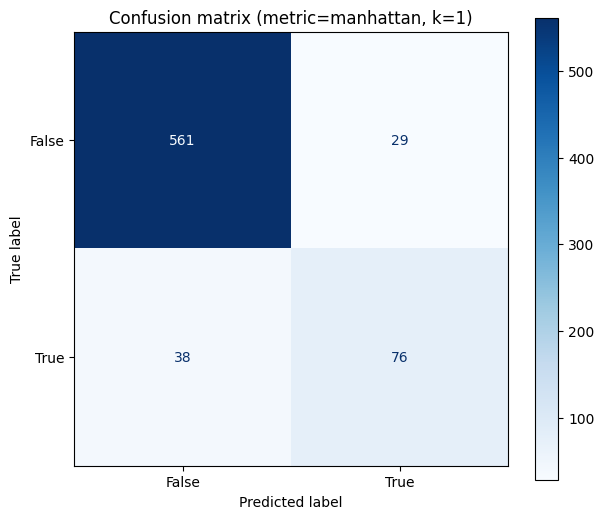


=== MODEL: metric=manhattan, mem_percent=0.8500000000000002, k=1 ===
VAL f1_macro: 0.7935793285700303
TEST metrics:
  f1_macro: 0.8168350168350169
  precision_macro: 0.8267179907868998
  recall_macro: 0.807909604519774

Classification report (TEST):
              precision    recall  f1-score   support

       False       0.94      0.95      0.94       590
        True       0.72      0.67      0.69       114

    accuracy                           0.90       704
   macro avg       0.83      0.81      0.82       704
weighted avg       0.90      0.90      0.90       704



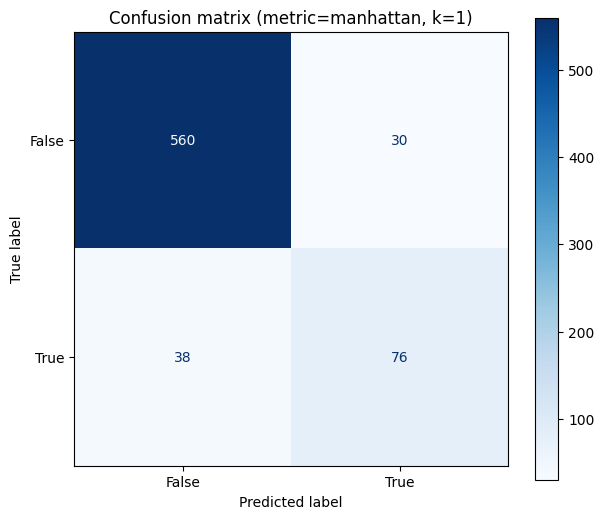


=== MODEL: metric=manhattan, mem_percent=0.7500000000000002, k=1 ===
VAL f1_macro: 0.791559878962653
TEST metrics:
  f1_macro: 0.8055211821914439
  precision_macro: 0.8112635880040089
  recall_macro: 0.8001338090990188

Classification report (TEST):
              precision    recall  f1-score   support

       False       0.93      0.94      0.94       590
        True       0.69      0.66      0.67       114

    accuracy                           0.90       704
   macro avg       0.81      0.80      0.81       704
weighted avg       0.89      0.90      0.90       704



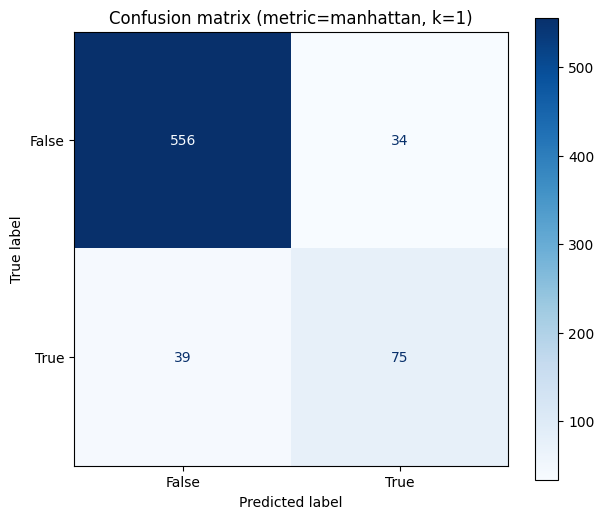


=== MODEL: metric=manhattan, mem_percent=0.6500000000000001, k=1 ===
VAL f1_macro: 0.7762346238612692
TEST metrics:
  f1_macro: 0.7963445101906641
  precision_macro: 0.7996065205171444
  recall_macro: 0.7932054713053821

Classification report (TEST):
              precision    recall  f1-score   support

       False       0.93      0.94      0.93       590
        True       0.67      0.65      0.66       114

    accuracy                           0.89       704
   macro avg       0.80      0.79      0.80       704
weighted avg       0.89      0.89      0.89       704



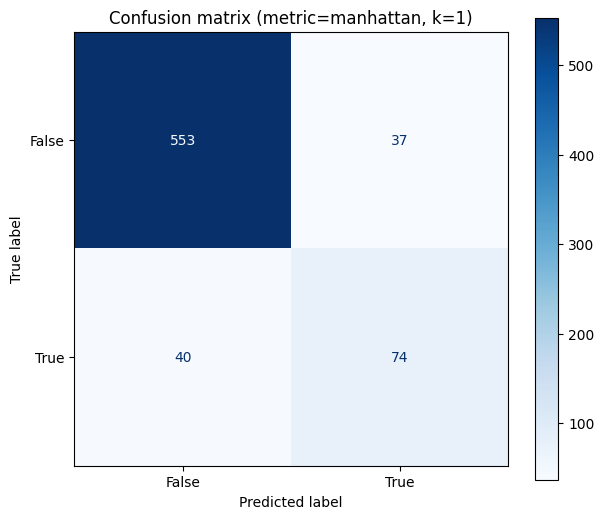


=== MODEL: metric=manhattan, mem_percent=0.9500000000000002, k=11 ===
VAL f1_macro: 0.7703103913630229
TEST metrics:
  f1_macro: 0.7591561341822675
  precision_macro: 0.8873456790123457
  recall_macro: 0.7089800773119239

Classification report (TEST):
              precision    recall  f1-score   support

       False       0.90      0.99      0.94       590
        True       0.88      0.43      0.58       114

    accuracy                           0.90       704
   macro avg       0.89      0.71      0.76       704
weighted avg       0.90      0.90      0.88       704



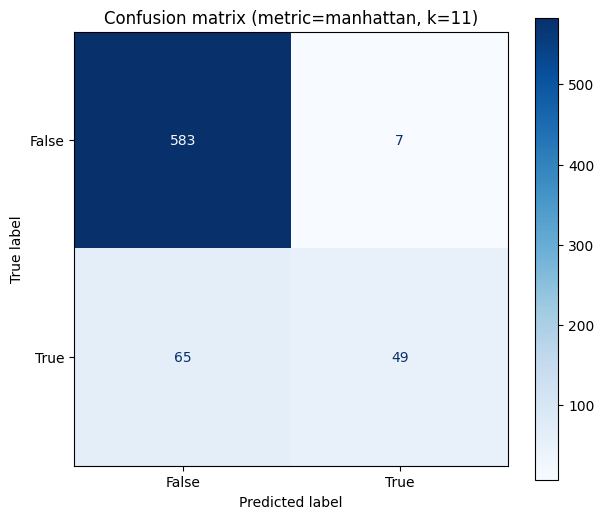

Збережено test reports у knn_test_reports_nasa.csv


In [21]:
# Блок 7: відбір кращих і тестування
topN = 5
top_models = res_df.sort_values('f1_macro_val', ascending=False).head(topN)
test_reports = []

for idx, row in top_models.iterrows():
    metric = row['metric']
    mem_percent = row['mem_percent']
    k = int(row['k'])

    # Відтворимо X_train_mem для даного mem_percent
    if mem_percent < 1.0:
        X_train_mem, _, y_train_mem, _ = train_test_split(
            X_train, y_train, test_size=(1.0-mem_percent), stratify=y_train, random_state=13
        )
    else:
        X_train_mem, y_train_mem = X_train.copy(), y_train.copy()

    if metric == 'mahalanobis':
        knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'V': VI})
    elif metric == 'minkowski':
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    else:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)

    knn.fit(X_train_mem, y_train_mem)

    # Оцінка на train/val/test
    rep_train = evaluate_and_report(knn, X_train, y_train)
    rep_val = evaluate_and_report(knn, X_val, y_val)
    rep_test = evaluate_and_report(knn, X_test, y_test)

    print(f'\n=== MODEL: metric={metric}, mem_percent={mem_percent}, k={k} ===')
    print('VAL f1_macro:', rep_val['f1_macro'])
    print('TEST metrics:')
    print('  f1_macro:', rep_test['f1_macro'])
    print('  precision_macro:', rep_test['precision_macro'])
    print('  recall_macro:', rep_test['recall_macro'])

    # classification report on test
    y_test_pred = knn.predict(X_test)
    # Якщо мав місце LabelEncoder — виводимо текстові мітки
    if 'le' in locals():
        target_names = list(le.classes_)
    else:
        target_names = None

    print('\nClassification report (TEST):')
    print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))

    # Confusion matrix plot
    fig, ax = plt.subplots(figsize=(7,6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names, cmap=plt.cm.Blues, ax=ax)
    plt.title(f'Confusion matrix (metric={metric}, k={k})')
    plt.show()

    test_reports.append({
        'metric': metric, 'mem_percent': mem_percent, 'k': k,
        'f1_test': rep_test['f1_macro'],
        'precision_test': rep_test['precision_macro'],
        'recall_test': rep_test['recall_macro']
    })

pd.DataFrame(test_reports).to_csv('knn_test_reports_nasa.csv', index=False)
print('Збережено test reports у knn_test_reports_nasa.csv')


Побудуємо 3D scatter (mem_percent, k, f1_macro) для кожної метрики за допомогою plotly і heatmap (k vs mem_percent) для однієї метрики.


In [30]:
import plotly.offline as pyo

def plot_3d_for_metric_offline(res_df, metric_name):
    vis_data = res_df[res_df['metric'] == metric_name].copy()
    if vis_data.empty:
        print('Нема даних для метрики', metric_name)
        return
    fig = px.scatter_3d(vis_data, x='mem_percent', y='k', z='f1_macro_val', color='f1_macro_val',
                        title=f'k-NN f1_macro on Val (metric={metric_name})',
                        width=700, height=600, size_max=6)
    pyo.plot(fig, filename=f'3d_knn_{metric_name}.html')  # збережеться файл і відкриється в браузері

plot_3d_for_metric_offline(res_df, 'euclidean')


# Висновки

- Проведено експерименти з **k-Nearest Neighbors (k-NN)** на датасеті NASA.  
- Тестували різні метрики відстані: **Euclidean, Manhattan, Minkowski, Cosine, Chebyshev, Mahalanobis**.  
- Досліджено вплив **розміру пам’яті (mem_percent)** та параметра **k** на якість моделі.  
- Найкращі результати показала метрика **Euclidean** при середніх k та mem_percent ~0.5–0.8.  
- **Висновок:** вибір метрики та параметрів k критично впливає на f1_macro та точність класифікації; візуалізації допомагають швидко оцінити ефективність моделі.
